In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import sys
import copy
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from mpl_toolkits.axes_grid1 import make_axes_locatable

sys.path.append('/mnt/c/Users/lslat/Code/')
sys.path.append('/mnt/c/Users/lslat/QiskitProjects/VariationalWavefunction/')

from quantum_kernel.code.utils import get_dataset,precomputed_kernel_GridSearchCV
from quantum_kernel.code.visualization_utils import aggregate_folder,filter_df
from quantum_kernel.code.kernel_measures.kernel_geometry import purity_average, purity_of_average
from sklearn.svm import SVC

font = {'family': 'DejaVu Sans',
        'weight': 'bold',
        'size': 18}

rc('font', **font)

tqdm.pandas()

In [6]:
# Get kernel results for the different ml models and dataset.d
dfs = {}
dataset_name='fashion-mnist'
folders = [
    ("/mnt/c/Users/lslat/Data/QK_project/results/hproj_HZZMulti/"+dataset_name,'HZZMulti',True),
]

for folder, kernel_name, projected in folders:
    if dataset_name in dfs:
        temp = aggregate_folder(folder, dataset_name, kernel_name=kernel_name,projected=projected)[
            dataset_name]
        dfs[dataset_name] = pd.concat([dfs[dataset_name], temp])
    else:
        dfs[dataset_name] = aggregate_folder(folder, dataset_name, kernel_name=kernel_name,projected=projected)[dataset_name]

save_folder='/mnt/c/Users/lslat/Data/QK_project/results/figs/'

100%|██████████| 196/196 [1:17:49<00:00, 23.82s/it]


For /mnt/c/Users/lslat/Data/QK_project/results/hproj_HZZMulti/fashion-mnist, saving aggregated pickle in /mnt/c/Users/lslat/Data/QK_project/results/hproj_HZZMulti/fashion-mnist/aggregated.p


In [7]:
def rdm_purity_info(df: pd.DataFrame,
    df_filter:dict,
    qubit: int = 0,
    ):
    new_df=filter_df(df,df_filter)

    lam1s=copy.copy(new_df['lam1'].values)
    lam1s=list(set(lam1s))
    lam1s.sort()

    lam2s=copy.copy(new_df['lam2'].values)
    lam2s=list(set(lam2s))
    lam2s.sort()
    
    pa_matrix=np.zeros((len(lam1s),len(lam2s)))
    pofa_matrix=np.zeros((len(lam1s),len(lam2s)))
    
    for i,lam1 in enumerate(lam1s):
        for j,lam2 in enumerate(lam2s):
            #try to compute rdm values
            try:
                rdms=new_df.loc[(new_df['lam1']==lam1) & (new_df['lam2']==lam2)]['rdms'].values[0]
                pa=purity_average(rdms)
                pofa=purity_of_average(rdms)
                pa_matrix[i,j]=pa[qubit]
                pofa_matrix[i,j]=pofa[qubit]
               
            #if fail set matrix element to -1
            except:
                pa_matrix[i,j]=-1
                pofa_matrix[i,j]=-1
    return pa_matrix,pofa_matrix,lam1s,lam2s

In [8]:
def kernel_info(
    df: pd.DataFrame,
    df_filter: dict,
    ):
    new_df=filter_df(df,df_filter)
    dataset_dims=copy.copy(new_df['dataset_dim'].values)
    dataset_dims=list(set(dataset_dims))
    dataset_dims.sort()

    kernels=[]
    for dim in dataset_dims:
        kernel=new_df.loc[(new_df['dataset_dim']==dim)]['qkern_matrix_train'].values[0]
        kernels.append(kernel)
    return kernels,dataset_dims

In [9]:
def test_score_info(df: pd.DataFrame,
    df_filter:dict,
    qubit: int = 0,
    ):
    new_df=filter_df(df,df_filter)

    lam1s=copy.copy(new_df['lam1'].values)
    lam1s=list(set(lam1s))
    lam1s.sort()

    lam2s=copy.copy(new_df['lam2'].values)
    lam2s=list(set(lam2s))
    lam2s.sort()
    
    score_matrix=np.zeros((len(lam1s),len(lam2s)))
    
    for i,lam1 in enumerate(lam1s):
        for j,lam2 in enumerate(lam2s):
            #try to compute rdm values
            try:
                score=new_df.loc[(new_df['lam1']==lam1) & (new_df['lam2']==lam2)]['test_score'].values[0]
                score_matrix[i,j]=score
            #if fail set matrix element to -1
            except:
                score_matrix[i,j]=-1
    return score_matrix,lam1s,lam2s

In [10]:
df=dfs[dataset_name]
dataset_dim=10
kernel_name='HZZMulti'
filter={'dataset_dim':dataset_dim,'evo_time':1.0,'n_trotter':10,'kernel_name':kernel_name}

In [11]:
pa_matrix, pofa_matrix, lam1s, lam2s = rdm_purity_info(df,filter)

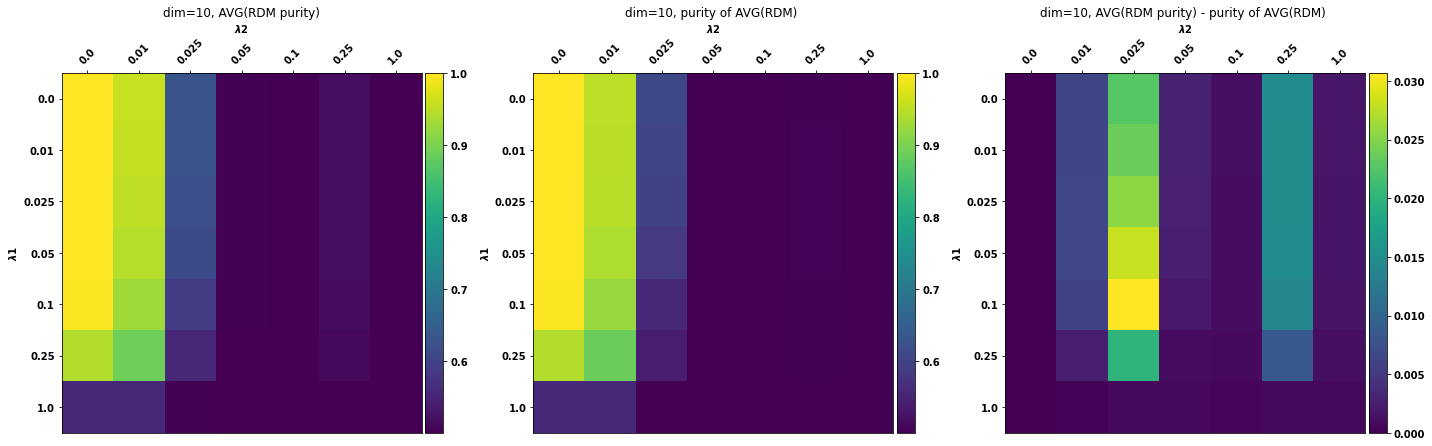

In [12]:
fig,axs=plt.subplots(1,3,figsize=(20,30))
####### is lambda 1 and lambda 2 in the right order?
ax = axs[0]
img = ax.imshow(pa_matrix)

ax.xaxis.tick_top()
ax.set_xticks(np.arange(len(lam2s)), minor=False)
ax.set_xticklabels(lam2s, rotation=45)
ax.set_xlabel(r'$\lambda 2$')
ax.xaxis.set_label_position('top')

ax.set_yticks(np.arange(len(lam1s)), minor=False)
ax.set_yticklabels(lam1s)
ax.set_ylabel(r'$\lambda 1$')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(img, cax=cax)

ax.set_title(rf'dim={dataset_dim}, AVG(RDM purity)')
#######
ax = axs[1]
img = ax.imshow(pofa_matrix)

ax.xaxis.tick_top()
ax.set_xticks(np.arange(len(lam2s)), minor=False)
ax.set_xticklabels(lam2s, rotation=45)
ax.set_xlabel(r'$\lambda 2$')
ax.xaxis.set_label_position('top')

ax.set_yticks(np.arange(len(lam1s)), minor=False)
ax.set_yticklabels(lam1s)
ax.set_ylabel(r'$\lambda 1$')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(img, cax=cax)

ax.set_title(rf'dim={dataset_dim}, purity of AVG(RDM) ')
#######
ax = axs[2]
img = ax.imshow(pa_matrix-pofa_matrix)

ax.xaxis.tick_top()
ax.set_xticks(np.arange(len(lam2s)), minor=False)
ax.set_xticklabels(lam2s, rotation=45)
ax.set_xlabel(r'$\lambda 2$')
ax.xaxis.set_label_position('top')

ax.set_yticks(np.arange(len(lam1s)), minor=False)
ax.set_yticklabels(lam1s)
ax.set_ylabel(r'$\lambda 1$')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(img, cax=cax)

ax.set_title(rf'dim={dataset_dim}, AVG(RDM purity) - purity of AVG(RDM) ')

fig.tight_layout()

fig.savefig(f'{save_folder}{dataset_name}_dim{dataset_dim}_{kernel_name}_purity_plots.pdf')

In [13]:
score_matrix, lam1s, lam2s = test_score_info(df,filter)

In [14]:
def highlight_cell(y,x, ax=None, **kwargs):
    rect = plt.Rectangle((x-.5, y-.5), 1,1, fill=False, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect

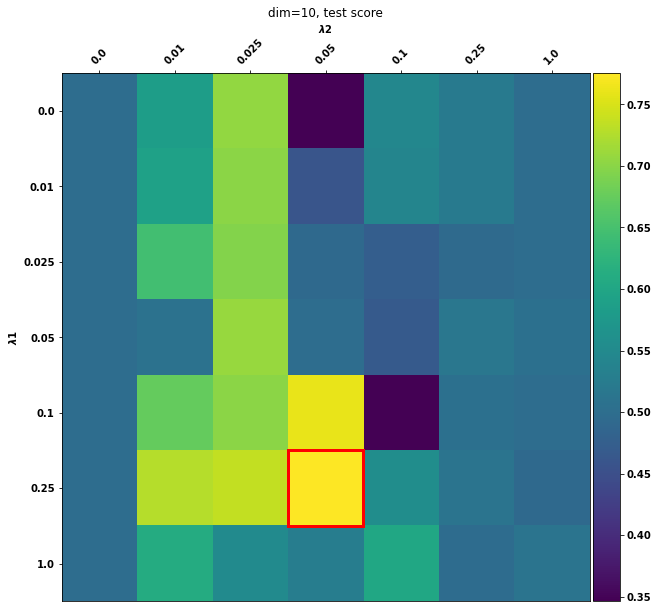

In [57]:
fig,axs=plt.subplots(1,1,figsize=(10,10))
####### is lambda 1 and lambda 2 in the right order?
ax = axs
img = ax.imshow(score_matrix)

#find indices for top 3 test scores. then highlight
#ii= (np.array[y1,y2,y3],np.array[x1,x2,x3],)
ii=np.unravel_index(np.flip(np.argsort(score_matrix.ravel()))[0:3], score_matrix.shape)
highlight_cell(ii[0][0],ii[1][0], color="red", linewidth=3)

ax.xaxis.tick_top()
ax.set_xticks(np.arange(len(lam2s)), minor=False)
ax.set_xticklabels(lam2s, rotation=45)
ax.set_xlabel(r'$\lambda 2$')
ax.xaxis.set_label_position('top')

ax.set_yticks(np.arange(len(lam1s)), minor=False)
ax.set_yticklabels(lam1s)
ax.set_ylabel(r'$\lambda 1$')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(img, cax=cax)

ax.set_title(rf'dim={dataset_dim}, test score')

fig.savefig(f'{save_folder}{dataset_name}_dim{dataset_dim}_{kernel_name}_score_grid.pdf')

In [96]:
df=dfs[dataset_name]
lam1=0.25

lam2=0.01
filter0={'evo_time':1.0,'n_trotter':10,'kernel_name':'HZZMulti','lam1':lam1,'lam2':lam2}

lam2=0.025
filter1={'evo_time':1.0,'n_trotter':10,'kernel_name':'HZZMulti','lam1':lam1,'lam2':lam2}

lam2=0.05
filter2={'evo_time':1.0,'n_trotter':10,'kernel_name':'HZZMulti','lam1':lam1,'lam2':lam2}

kernels0,dims=kernel_info(df,filter0)
kernels1,dims=kernel_info(df,filter1)
kernels2,dims=kernel_info(df,filter2)


In [97]:
gamma=1

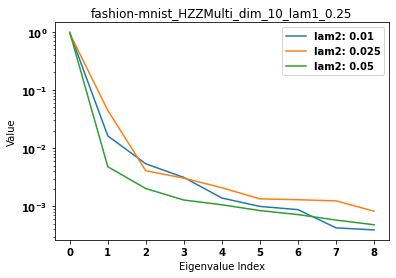

In [98]:
n=3

w,v=np.linalg.eig(np.exp(-gamma*kernels0[n]))
size=len(w)
plt.plot(np.sort(w)[-1:790:-1]/size,label='lam2: 0.01')

w,v=np.linalg.eig(np.exp(-gamma*kernels1[n]))
plt.plot(np.sort(w)[-1:790:-1]/size,label='lam2: 0.025')

w,v=np.linalg.eig(np.exp(-gamma*kernels2[n]))
plt.plot(np.sort(w)[-1:790:-1]/size,label='lam2: 0.05')

plt.yscale('log')

plt.ylabel('Value')
plt.xlabel('Eigenvalue Index')

plt.title(f'{dataset_name}_HZZMulti_dim_{dims[3]}_lam1_{lam1}')
plt.legend()
plt.savefig(f'{save_folder}{dataset_name}_dim{dataset_dim}_{kernel_name}_lam1_{lam1}_lam2vary_eigenvalues.pdf')

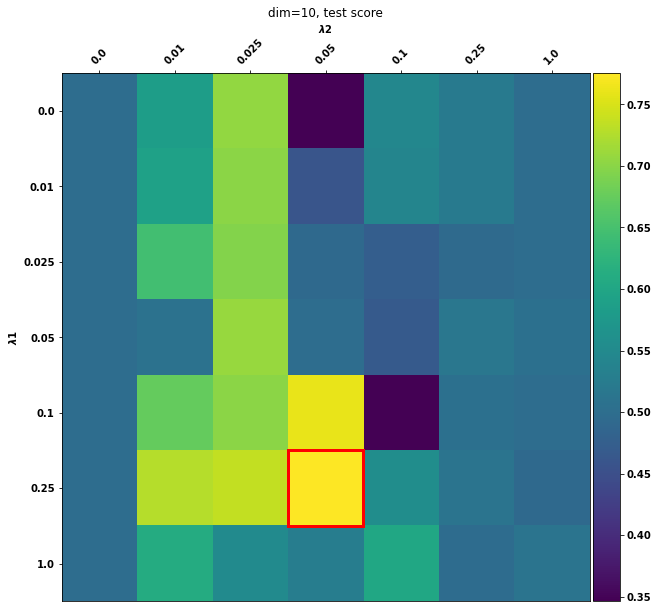

In [85]:
fig,axs=plt.subplots(1,1,figsize=(10,10))
####### is lambda 1 and lambda 2 in the right order?
ax = axs
img = ax.imshow(score_matrix)

#find indices for top 3 test scores. then highlight
#ii= (np.array[y1,y2,y3],np.array[x1,x2,x3],)
ii=np.unravel_index(np.flip(np.argsort(score_matrix.ravel()))[0:3], score_matrix.shape)
highlight_cell(ii[0][0],ii[1][0], color="red", linewidth=3)

ax.xaxis.tick_top()
ax.set_xticks(np.arange(len(lam2s)), minor=False)
ax.set_xticklabels(lam2s, rotation=45)
ax.set_xlabel(r'$\lambda 2$')
ax.xaxis.set_label_position('top')

ax.set_yticks(np.arange(len(lam1s)), minor=False)
ax.set_yticklabels(lam1s)
ax.set_ylabel(r'$\lambda 1$')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(img, cax=cax)

ax.set_title(rf'dim={dataset_dim}, test score')

fig.savefig(f'{save_folder}{dataset_name}_dim{dataset_dim}_{kernel_name}_score_grid.pdf')

/home/lslattery/anaconda3/envs/quantum_kernel/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


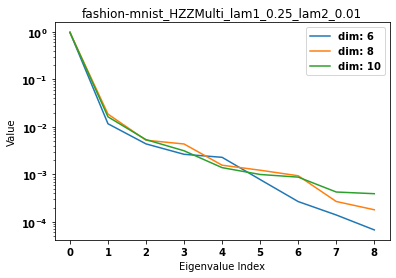

In [86]:
w1,_=np.linalg.eig(np.exp(-gamma*kernels0[1]))
plt.plot(np.sort(w1)[-1:790:-1]/size,label=f'dim: {dims[1]}')

w2,_=np.linalg.eig(np.exp(-gamma*kernels0[2]))
plt.plot(np.sort(w2)[-1:790:-1]/size,label=f'dim: {dims[2]}')

w3,_=np.linalg.eig(np.exp(-gamma*kernels0[3]))
plt.plot(np.sort(w3)[-1:790:-1]/size,label=f'dim: {dims[3]}')

plt.yscale('log')
plt.ylabel('Value')
plt.xlabel('Eigenvalue Index')
plt.title(f'{dataset_name}_HZZMulti_lam1_{lam1}_lam2_0.01')

plt.legend()
plt.savefig(f'{save_folder}{dataset_name}_dim{dataset_dim}_{kernel_name}_lam1_{lam1}_lam2_0.01_eigenvalues.pdf')

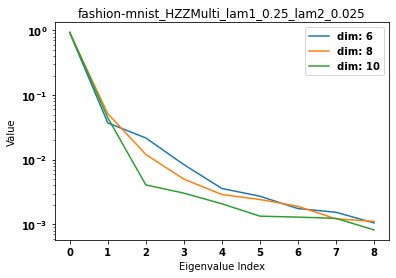

In [87]:
w1,_=np.linalg.eig(np.exp(-gamma*kernels1[1]))
plt.plot(np.sort(w1)[-1:790:-1]/size,label=f'dim: {dims[1]}')

w2,_=np.linalg.eig(np.exp(-gamma*kernels1[2]))
plt.plot(np.sort(w2)[-1:790:-1]/size,label=f'dim: {dims[2]}')

w3,_=np.linalg.eig(np.exp(-gamma*kernels1[3]))
plt.plot(np.sort(w3)[-1:790:-1]/size,label=f'dim: {dims[3]}')

plt.yscale('log')
plt.ylabel('Value')
plt.xlabel('Eigenvalue Index')
plt.title(f'{dataset_name}_HZZMulti_lam1_{lam1}_lam2_0.025')

plt.legend()
plt.savefig(f'{save_folder}{dataset_name}_dim{dataset_dim}_{kernel_name}_lam1_{lam1}_lam2_0.025_eigenvalues.pdf')

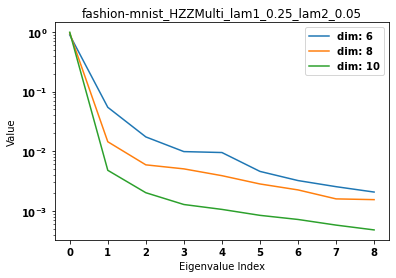

In [88]:
w1,_=np.linalg.eig(np.exp(-gamma*kernels2[1]))
plt.plot(np.sort(w1)[-1:790:-1]/size,label=f'dim: {dims[1]}')

w2,_=np.linalg.eig(np.exp(-gamma*kernels2[2]))
plt.plot(np.sort(w2)[-1:790:-1]/size,label=f'dim: {dims[2]}')

w3,_=np.linalg.eig(np.exp(-gamma*kernels2[3]))
plt.plot(np.sort(w3)[-1:790:-1]/size,label=f'dim: {dims[3]}')

plt.yscale('log')
plt.ylabel('Value')
plt.xlabel('Eigenvalue Index')
plt.title(f'{dataset_name}_HZZMulti_lam1_{lam1}_lam2_0.05')

plt.legend()
plt.savefig(f'{save_folder}{dataset_name}_dim{dataset_dim}_{kernel_name}_lam1_{lam1}_lam2_0.05_eigenvalues.pdf')

In [64]:
df=dfs[dataset_name]
kernel_name='HZZMulti'

best_scores=[]
for dataset_dim in dims:
    filter={'dataset_dim':dataset_dim,'evo_time':1.0,'n_trotter':10,'kernel_name':kernel_name}
    score_matrix, lam1s, lam2s = test_score_info(df,filter)
    best_scores.append(score_matrix.max())

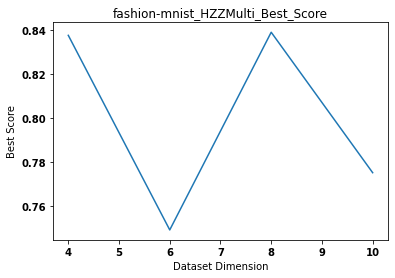

In [65]:
plt.plot(dims,best_scores)
plt.title(f'{dataset_name}_HZZMulti_Best_Score')
plt.xlabel('Dataset Dimension')
plt.ylabel('Best Score')
plt.savefig(f'{save_folder}{dataset_name}_{kernel_name}_best_scores.pdf')